<img src="titanic.jpg" width="500" height="340"> 

<p><justify> In this project we are going to predict passenger survival using the famous Titanic dataset, this is one of the first Kaggle competitions you face as a beginner kaggler. The dataset is a good example of how feature engineering can impact the model performance.Exploratory data analysis will help us to explore to relevance of different features.The performance of each model is measure using the accuracy and a voting classifier is built to make the final prediction. We are going to exemplify the use of pipelines to automate the prediction process.</justify><p>

# Importing libraries and the dataset

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import Pipeline,FunctionTransformer,make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn import set_config

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

import re
import missingno as msno

pd.options.mode.chained_assignment = None

In [4]:
df_train = pd.read_csv("train.csv",index_col='PassengerId')
df_test = pd.read_csv("test.csv",index_col='PassengerId')

In [5]:
df_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [6]:
df_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


The dataset is a mixture of numerical and categorical data. First let's see if we have missing or duplicate values.

## Checking Integrity

<Axes: >

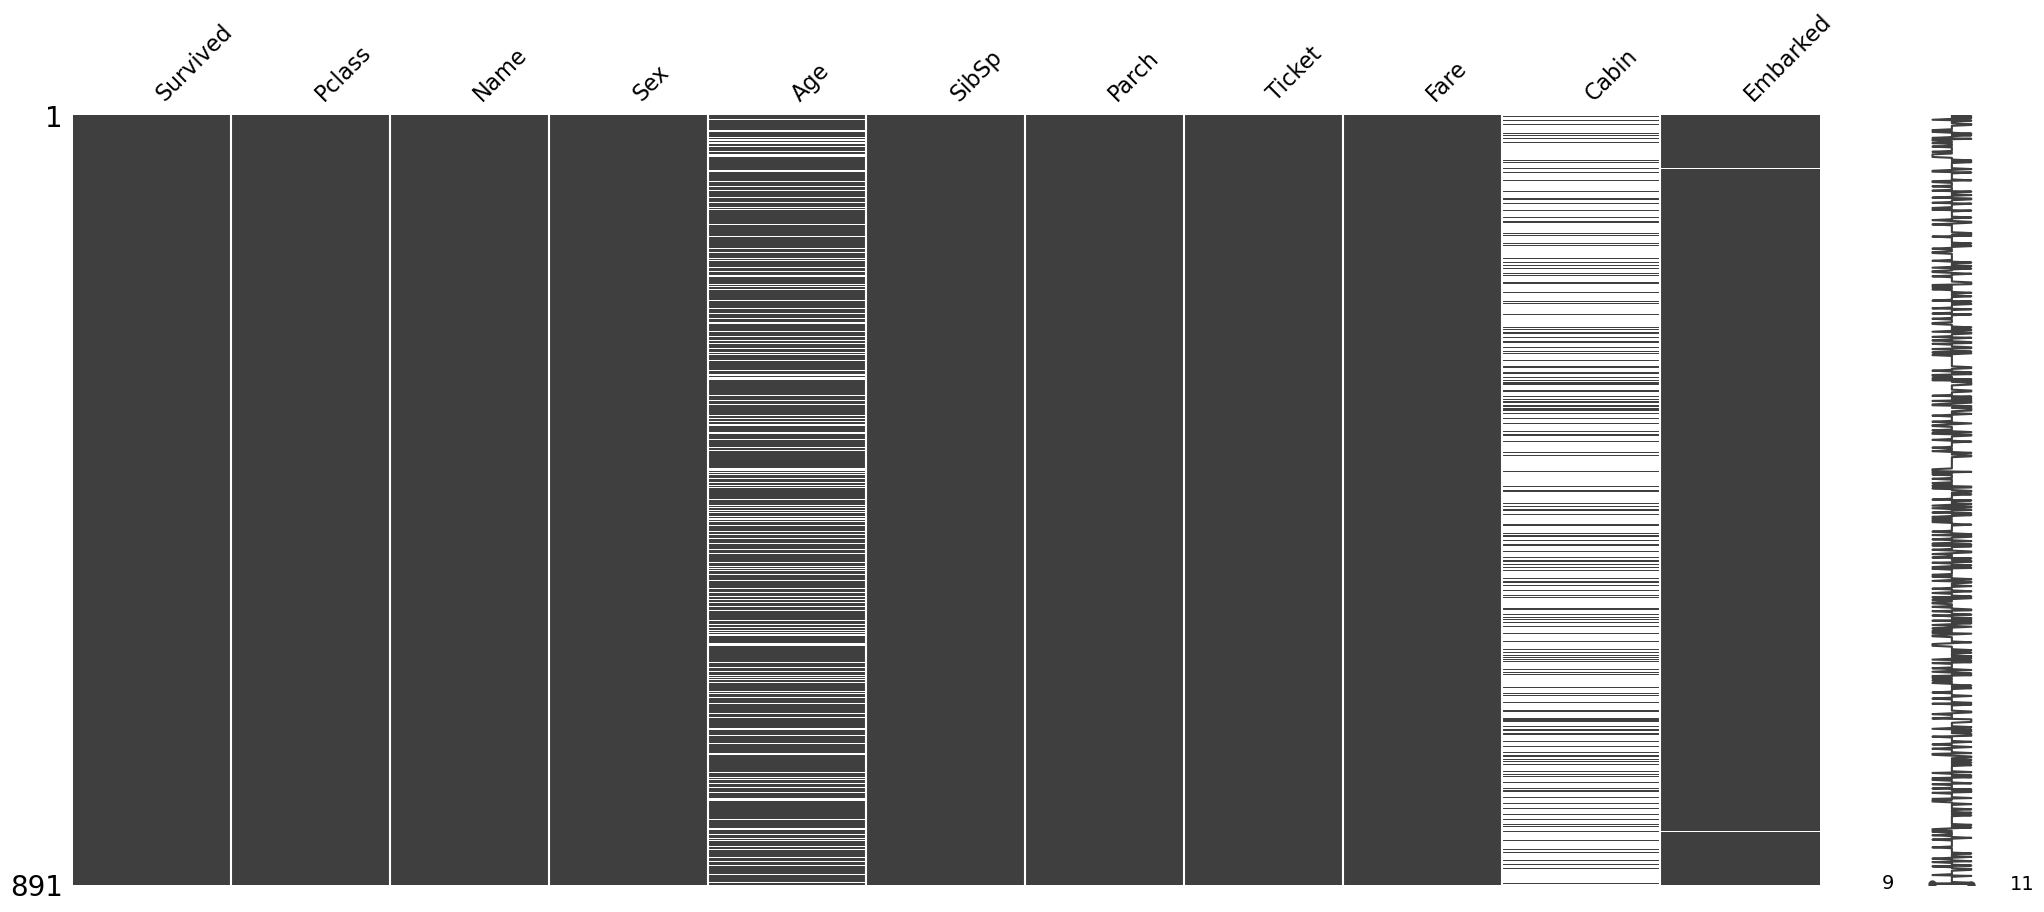

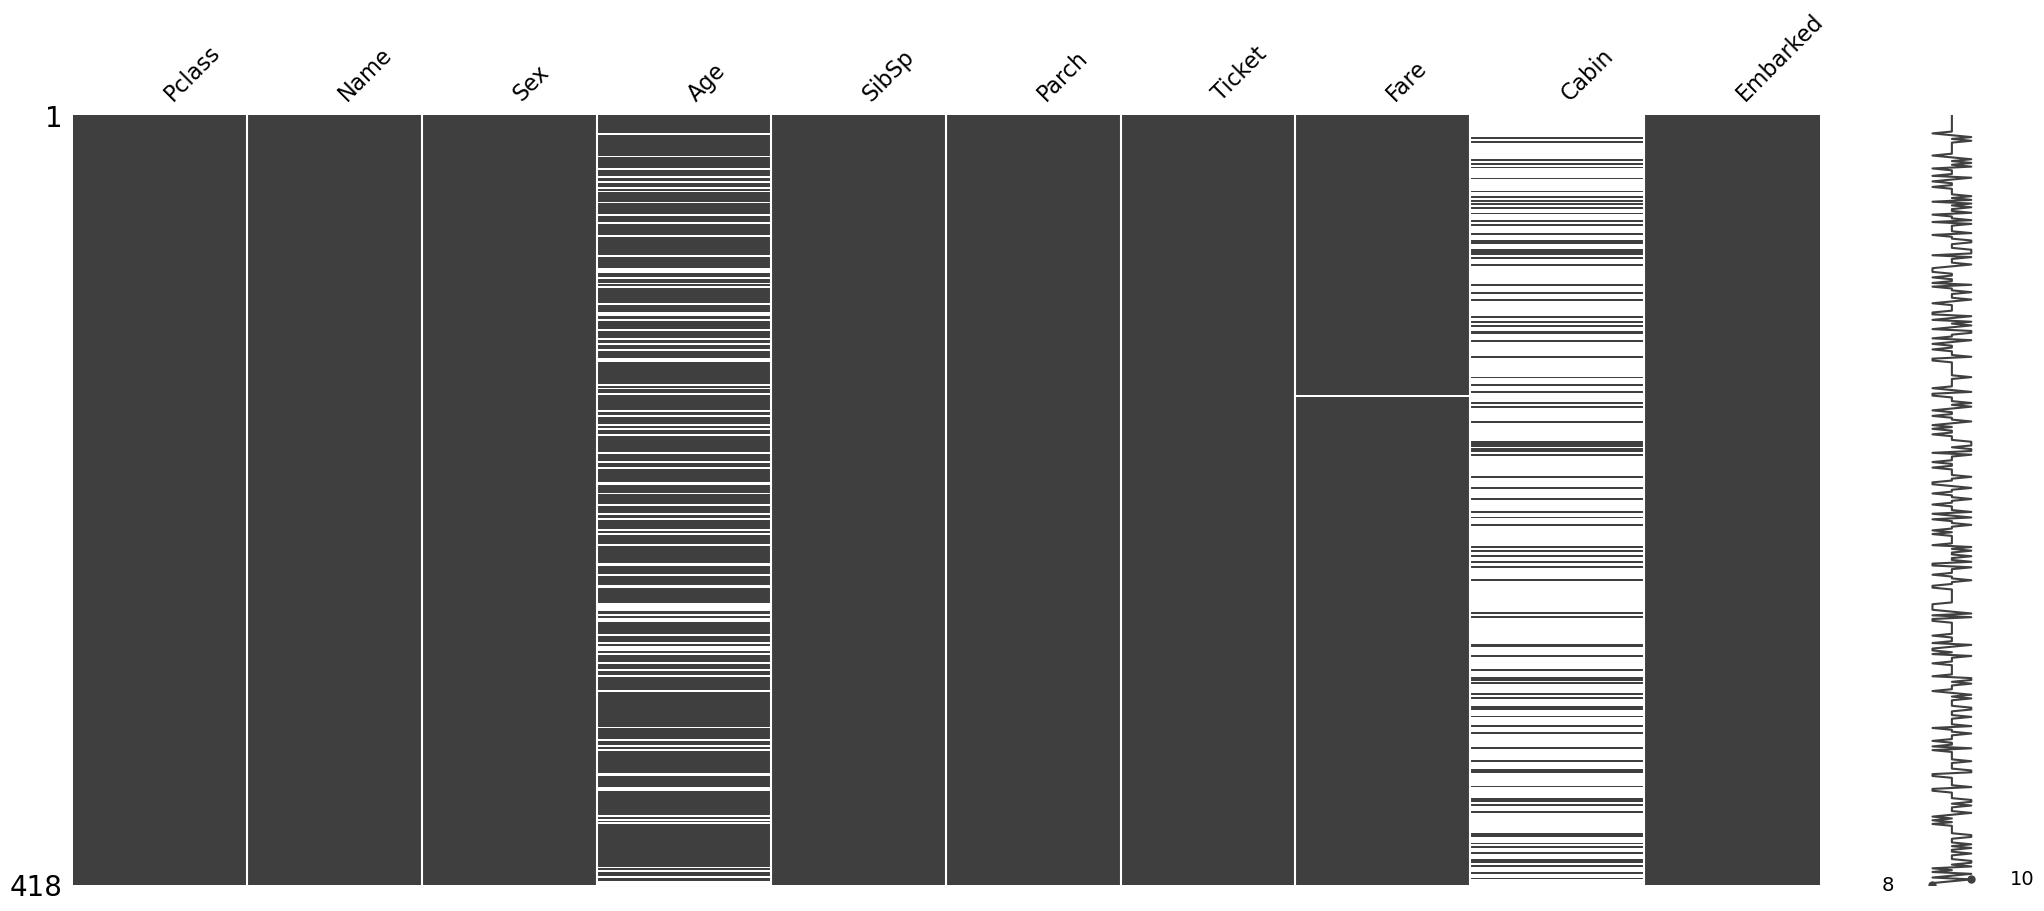

In [8]:
# check pattern of missingness
msno.matrix(df_train)
msno.matrix(df_test)

In [9]:
duplicates_train = df_train[df_train.duplicated()]
duplicates_test = df_test[df_test.duplicated()]
                             
print(f'Number of duplicates in training data:',len(duplicates_train))
print(f'Number of duplicates in test data:',len(duplicates_test))

Number of duplicates in training data: 0
Number of duplicates in test data: 0


As we can see we have no duplicates but we have a lot of missing data in Age and Cabin column. We will keep them from now, to see if we can figure out how to fill them. The Fare and Embarked column also have missing valules, but just two and one respectively, it will be better to impute them later.

# Exploratory Data Analysis

Let's take a look at the overall survival.

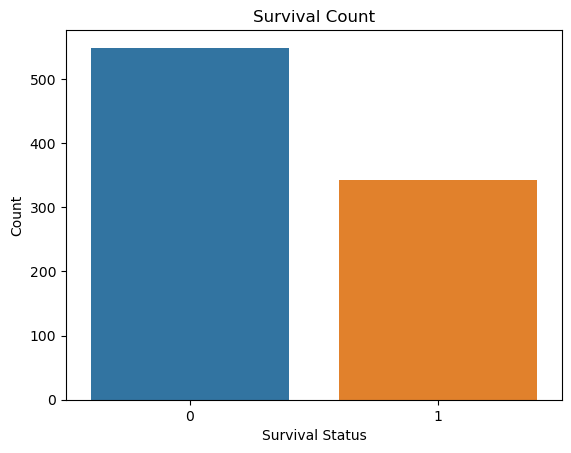

In [10]:
# Bar plot of Survivors
sns.countplot(x='Survived', data=df_train)
plt.xlabel('Survival Status')
plt.ylabel('Count')
plt.title('Survival Count')
plt.show()

In [11]:
df_train.groupby('Survived',as_index=False)['Survived'].agg(['count'])

,Survived,count
0,0,549
1,1,342


It is clear that not many persons survived. Out of 891 persons only 342 survived,approximately 38% of the passengers.

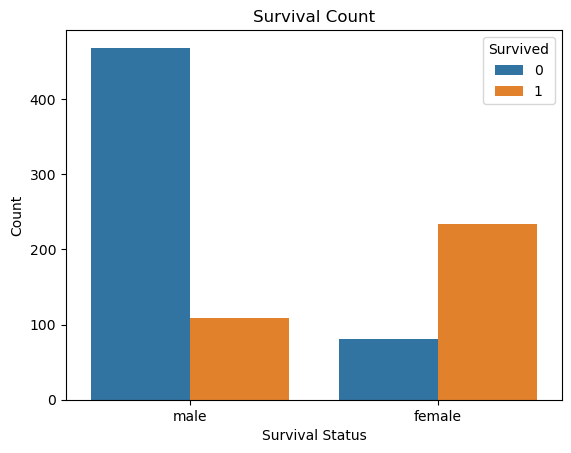

In [12]:
# Bar plot of Survivors per sex
sns.countplot(x='Sex', data=df_train,hue='Survived')
plt.xlabel('Survival Status')
plt.ylabel('Count')
plt.title('Survival Count')
plt.show()

In [13]:
df_train.groupby('Sex',as_index=False)['Survived'].agg(['mean','count'])

,Sex,mean,count
0,female,0.742038,314
1,male,0.188908,577


Female survival ratio is much greater than that of male. 233 female survived out of 344 againts 109 male out of 577.

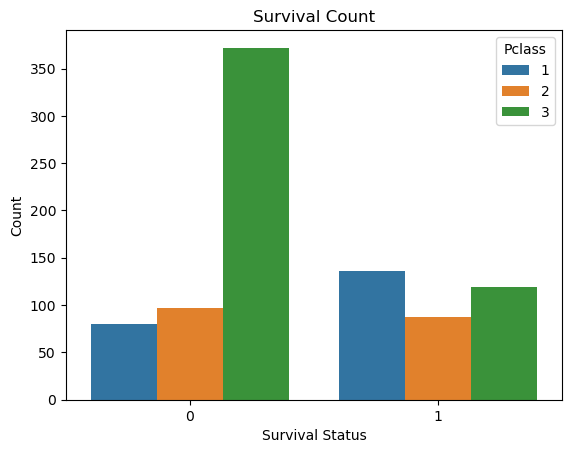

In [14]:
# Bar plot of Survivors per class
sns.countplot(x='Survived', data=df_train,hue='Pclass')
plt.xlabel('Survival Status')
plt.ylabel('Count')
plt.title('Survival Count')
plt.show()

In [15]:
df_train.groupby('Pclass',as_index=False)['Survived'].agg(['mean','count'])

,Pclass,mean,count
0,1,0.629630,216
1,2,0.472826,184
2,3,0.242363,491


Pasangers of Class 1 were given high priority during rescue. There are more passengers in Class 3 than in Class 1 and 2 combined but only 24%, survived. In Class 2, survival rate is 47%. While in Class 1 almost 63% of people survived. Undoubtedly, money and class matters.

In [16]:
pd.crosstab([df_train['Sex'],df_train['Survived']],df_train['Pclass'],margins=True).style.background_gradient(cmap='coolwarm')

Let's explore the influence of age in the survival. Let's see if the comply with "Women and children first".

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


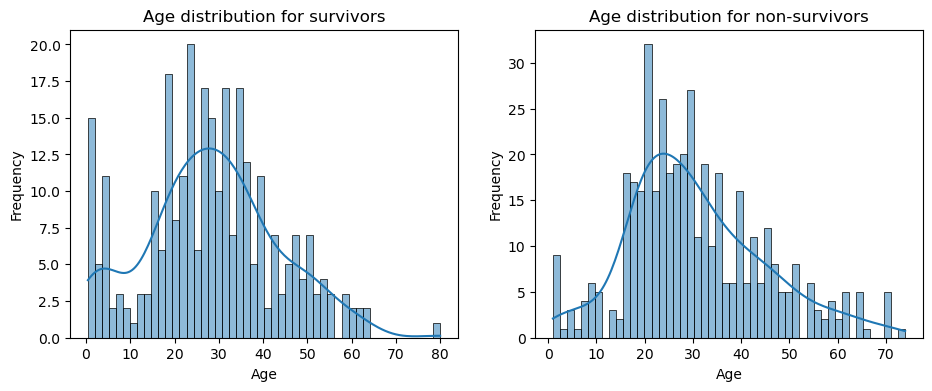

In [17]:
survived = df_train.loc[df_train['Survived']==1]
perished = df_train.loc[df_train['Survived']==0]

# Histogram of Age 
fig,axs = plt.subplots(1,2,figsize=(11,4))
g = sns.histplot(data=survived,x='Age',bins=50,kde=True,ax=axs[0])
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g.set_title('Age distribution for survivors')
f = sns.histplot(data=perished,x='Age',bins=50,kde=True,ax=axs[1])
f.set_xlabel('Age')
f.set_ylabel('Frequency')
f.set_title('Age distribution for non-survivors')
plt.show()

Both distribution look very similar, probably because in young and adult couples, the male partner prefer to save his wife or girlfriend. There is a peak below 10 years in the survivors histogram, so they really save children first. 

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


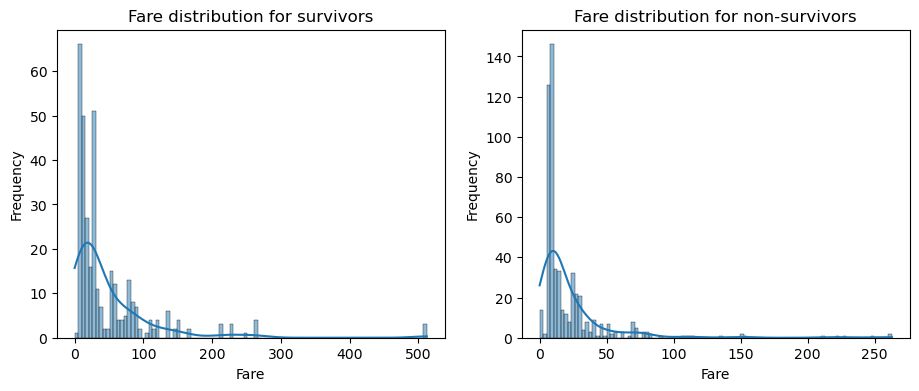

In [18]:
survived = df_train.loc[df_train['Survived']==1]
perished = df_train.loc[df_train['Survived']==0]

# Histogram of Fare
fig,axs = plt.subplots(1,2,figsize=(11,4))
g = sns.histplot(data=survived,x='Fare',bins=100,kde=True,ax=axs[0])
g.set_xlabel('Fare')
g.set_ylabel('Frequency')
g.set_title('Fare distribution for survivors')
f = sns.histplot(data=perished,x='Fare',bins=100,kde=True,ax=axs[1])
f.set_xlabel('Fare')
f.set_ylabel('Frequency')
f.set_title('Fare distribution for non-survivors')
plt.show()

As we can see money plays its role in survival since most people paying less than 50 pounds perished. We can see that fare distribution is right skewed. We could later apply some power transformation to the data.

Let's explore the relationship between age, passenger class and sex with survival through violin plots.

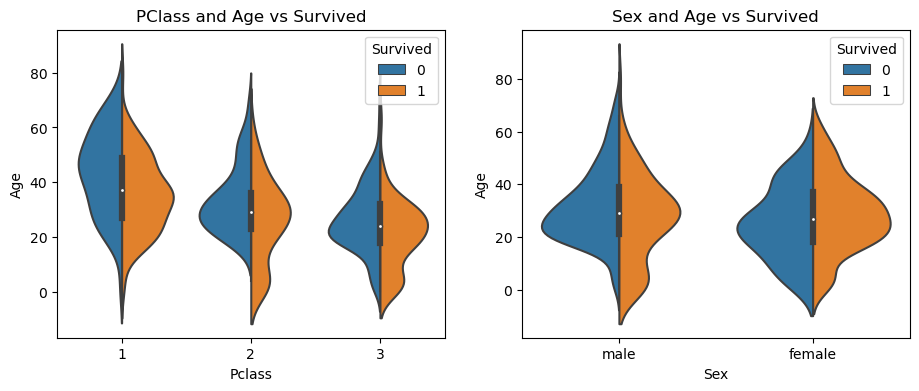

In [21]:
fig,axs = plt.subplots(1,2,figsize=(11,4))
g =sns.violinplot(x='Pclass',y='Age',hue='Survived',data=df_train,split=True,ax=axs[0])
g.set_title('PClass and Age vs Survived')
f=sns.violinplot(x="Sex",y="Age", hue="Survived", data=df_train,split=True,ax=axs[1])
f.set_title('Sex and Age vs Survived')
plt.show()

As we can see almost all distributions looks very similar except for the first class, where the age distribution is shifted towards lower values in the case of survivors.

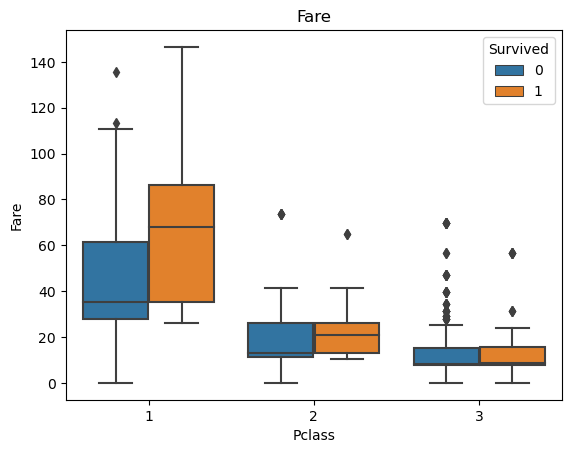

In [22]:
sns.boxplot(x='Pclass',y='Fare',hue='Survived',data=df_train[df_train['Fare']<=150])
plt.title('Fare')
plt.show()

The fare distribution exhibit some outliers, but we can see that in first class, the mean fare is greater for those who survived.

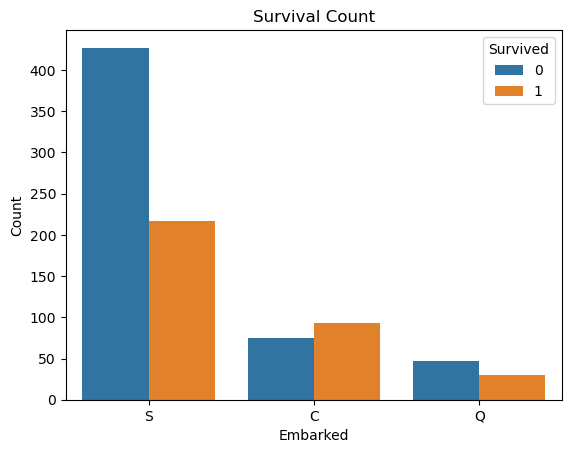

In [23]:
# Bar plot of Survivors per Embarked 
sns.countplot(x='Embarked', data=df_train,hue='Survived')
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.title('Survival Count')
plt.show()

In [24]:
df_train.groupby('Embarked',as_index=False)['Survived'].agg(['mean','count'])

,Embarked,mean,count
0,C,0.553571,168
1,Q,0.389610,77
2,S,0.336957,644


People embarked primarily from Southampton , but the ones that embarked from Cherbourg had a higher survival rate.

# Feature Engineering

We can create some relevant features before proceeding with the exploratory analysis. Title can be extracted from the passenger's name which could reveal its social and marital status and could be useful when filling the age column. From the apparently uninformative (high number of missing values) Cabin column the deck number can be extracted which could reveal some survival pattern. The length of the name could also be a potential indicator of status (people of higher classes tend to have very intricate names). Columns SibSp and Parch can be summarized in a Family Size column. Finally, we are goig to extract the number of tickets a person purchased.   

## Creating new categorical and numerical features 

In [25]:
def create_features(df):
        df = df.copy()
        # Fill NaN values in Fare and Age
        df['Fare'] = df['Fare'].fillna(df['Fare'].median())
        df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
        # Extracting Title from Name
        df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=False)
        df['Title'] = df['Title'].replace(['Capt', 'Col','Major'], 'Mr')
        df['Title'] = df['Title'].replace(['Rev', 'Dr'], 'Mr')
        df['Title'] = df['Title'].replace(['Don', 'Sir', 'Jonkheer'], 'Mr')
        df['Title'] = df['Title'].replace('Mlle', 'Miss')
        df['Title'] = df['Title'].replace(['Mme','Ms'], 'Mrs')
        df['Title'] = df['Title'].replace(['Lady', 'Countess','Dona'],'Mrs')
        # Extracting Name Length
        df['Name_Length'] = df['Name'].apply(lambda x: len(x))
        #Extracting Deck from Cabin
        df['Deck'] = df['Cabin'].fillna("U")
        df['Deck'] = df['Deck'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
        df['Deck'] = df['Deck'].apply(lambda x: 0 if x=='U' else 1)
        #extracting Ticket Number Counts from Ticket
        #ticket_map = {1: 0, 2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2}
        df['TicketNumber'] = df['Ticket'].apply(lambda x: x.split()[-1]) 
        df['TicketNumberCounts'] = df.groupby('TicketNumber')['TicketNumber'].transform('count')
        #df['TicketNumberCounts']  = df['TicketNumberCounts'].map(ticket_map)
        df = df.drop('TicketNumber',axis=1)
        #Extracting Family Size from SibSp and Parch
        #family_map = {1: 0, 2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 3, 11: 3}
        df['Family_Size'] = df['SibSp'] + df['Parch'] + 1
        #df['Family_Size'] = df['Family_Size'].map(family_map)       
        #Dropping Transformed features
        df = df.drop(['Name','SibSp','Parch','Ticket','Cabin'], axis = 1)

        return df

In [26]:
df_train = create_features(df_train)
df_test = create_features(df_test)

A clever way to fill the age column would be to look at the title corresponding to that age. For each title we can define a mean age an standard deviation and construct and interval (mean-std,mean+std) to generate an array of integer random numbers the size of the number of NaN values in the age column corresponding to that title. Finally,we fill NaN values corresponding to that title with the array of random numbers.

In [27]:
def fill_age(df):
    df = df.copy() 
    # Extracting Title from Name
    titles = df['Title'].unique().tolist() 
    for title in titles:
        
        mean = df.loc[df['Title']==title,'Age'].mean()
        std = df.loc[df['Title']==title,'Age'].std()
        length = df.loc[df['Title']==title,'Age'].isnull().sum() 
        
        to_fill = np.random.randint(mean-std,mean+std,length)
        df.loc[(df['Title']==title) & (df['Age'].isnull()),'Age'] = to_fill
    return df       

In [28]:
df_train = fill_age(df_train)
df_test = fill_age(df_test)

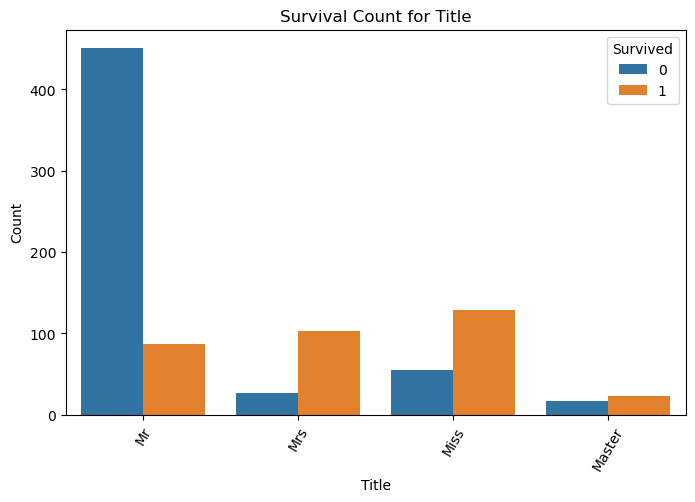

In [29]:
# Bar plot of Survivors per title
fig,ax = plt.subplots(figsize=(8,5))
g = sns.countplot(x='Title', data=df_train,hue='Survived')
g.set_xlabel('Title')
g.tick_params(axis='x', rotation=60)
g.set_ylabel('Count')
g.set_title('Survival Count for Title')
plt.show()

Once again its confirmed that women and children were given priority on the rescue boats.

In [30]:
df_train.groupby('Title',as_index=False)['Survived'].agg(['mean','count'])

,Title,mean,count
0,Master,0.575000,40
1,Miss,0.701087,184
2,Mr,0.161710,538
3,Mrs,0.798450,129


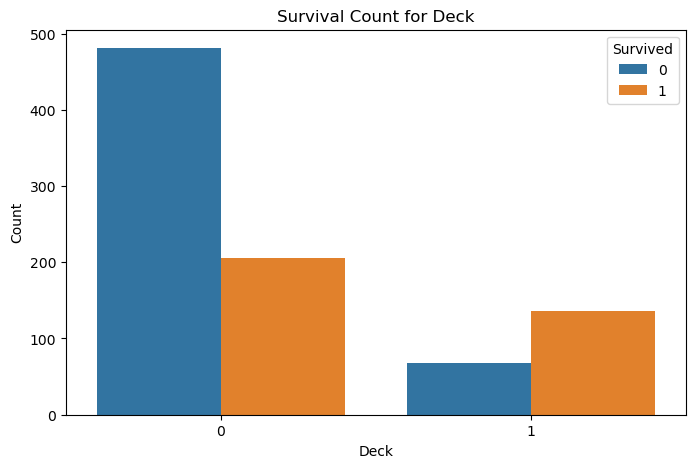

In [31]:
# Bar plot of Survivors per Deck Number
fig,ax = plt.subplots(figsize=(8,5))
g = sns.countplot(x='Deck', data=df_train,hue='Survived')
g.set_xlabel('Deck')
g.set_ylabel('Count')
g.set_title('Survival Count for Deck')
plt.show()

People with unknown Deck number (No Cabin assigned) were less fortunate in the shipwreck 

In [32]:
df_train.groupby('Deck',as_index=False)['Survived'].agg(['mean','count'])

,Deck,mean,count
0,0,0.299854,687
1,1,0.666667,204


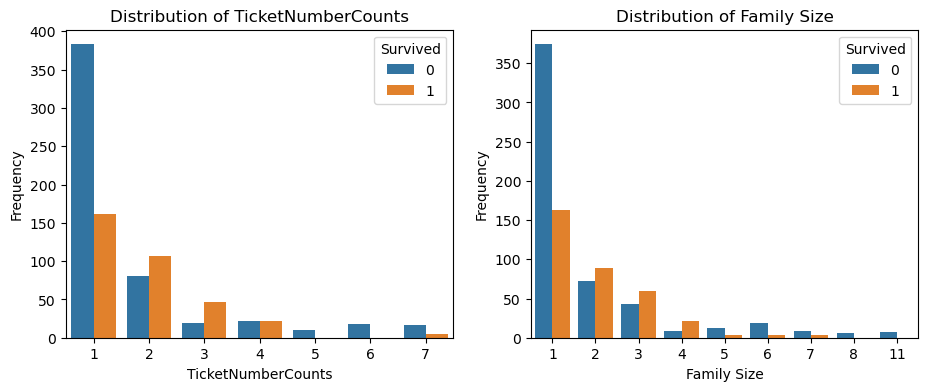

In [33]:
# Histogram of TicketNumberCounts and Family_Size
fig,axs = plt.subplots(1,2,figsize=(11,4))
g = sns.countplot(data=df_train,x='TicketNumberCounts',hue='Survived',ax=axs[0])
g.set_xlabel('TicketNumberCounts')
g.set_ylabel('Frequency')
g.set_title('Distribution of TicketNumberCounts')
f = sns.countplot(data=df_train,x='Family_Size',hue='Survived',ax=axs[1])
f.set_xlabel('Family Size')
f.set_ylabel('Frequency')
f.set_title('Distribution of Family Size')
plt.show()

In [34]:
pd.crosstab(df_train['Survived'],df_train['TicketNumberCounts'],margins=True).style.background_gradient(cmap='coolwarm')

TicketNumberCounts,1,2,3,4,5,6,7,All
Survived,,,,,,,,
0,383,81,19,22,10,18,16,549
1,161,107,47,22,0,0,5,342
All,544,188,66,44,10,18,21,891


In [35]:
pd.crosstab(df_train['Survived'],df_train['Family_Size'],margins=True).style.background_gradient(cmap='coolwarm')

Family_Size,1,2,3,4,5,6,7,8,11,All
Survived,,,,,,,,,,
0,374,72,43,8,12,19,8,6,7,549
1,163,89,59,21,3,3,4,0,0,342
All,537,161,102,29,15,22,12,6,7,891


People who bought 2,3 or 4 tickets had greater chances of surviving. Regarding family size, traveling with a small family 2,3 or 4 was crucial for surviving as compared to traveling alone or with a big family (more than 4 members).

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


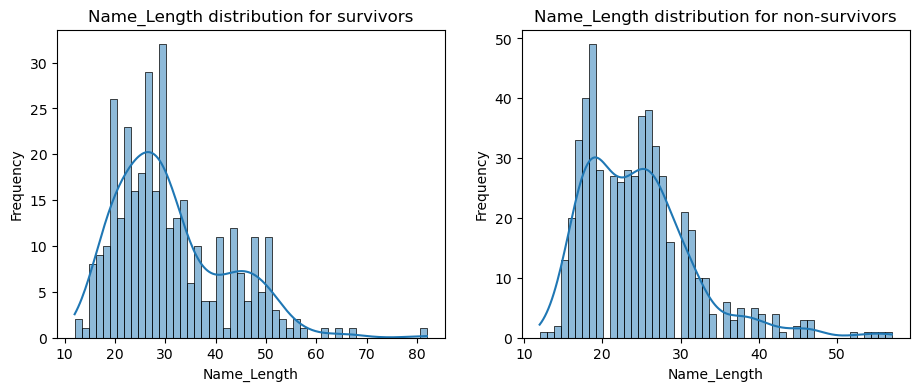

In [36]:
survived = df_train.loc[df_train['Survived']==1]
perished = df_train.loc[df_train['Survived']==0]

# Histogram of Age 
fig,axs = plt.subplots(1,2,figsize=(11,4))
g = sns.histplot(data=survived,x='Name_Length',bins=50,kde=True,ax=axs[0])
g.set_xlabel('Name_Length')
g.set_ylabel('Frequency')
g.set_title('Name_Length distribution for survivors')
f = sns.histplot(data=perished,x='Name_Length',bins=50,kde=True,ax=axs[1])
f.set_xlabel('Name_Length')
f.set_ylabel('Frequency')
f.set_title('Name_Length distribution for non-survivors')
plt.show()

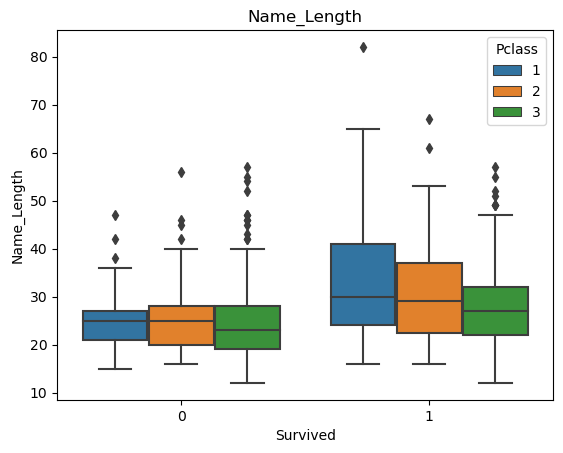

In [37]:
sns.boxplot(x='Survived',y='Name_Length',hue='Pclass',data=df_train)
plt.title('Name_Length')
plt.show()

People who survived had in average longer names than those who didn't make it. We can see in the histograms that in the case of survivors the peak is arounf 30 characters as compared to the 20 charcters peak for non-survivors.

### Correlation Matrix

In [38]:
corr = df_train[['Survived','Pclass','Age','Fare','Name_Length','TicketNumberCounts','Family_Size']].corr()
trimask = np.triu(np.ones_like(corr, dtype=bool))
corrmask = trimask | (np.abs(corr) <= 0.2)

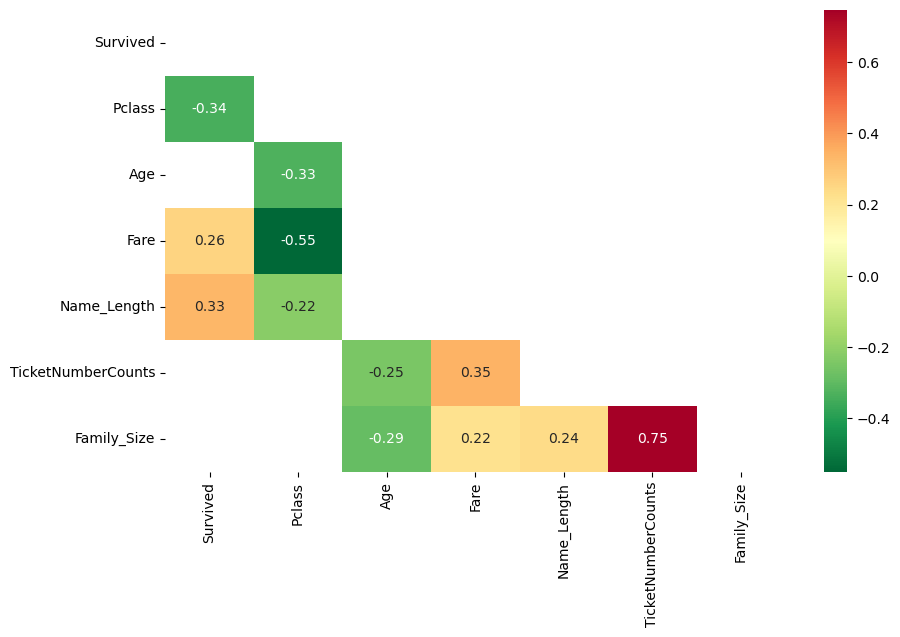

In [39]:
fig, ax = plt.subplots(figsize = (10,6))
g = sns.heatmap(corr, annot=True,cmap='RdYlGn_r',mask =corrmask,  fmt='.2f',ax=ax)
plt.show()

We can see that Name_Length, Fare and Pclass have the highest correlation with Survived.

## Encoding Categorical Features

Let's use ordinal encoder to transform Sex, Title,Embarked and Deck features.

In [40]:
ord_encoder = OrdinalEncoder().set_output(transform="pandas")

In [41]:
df_train[['Sex','Title','Embarked','Deck']] =ord_encoder.fit_transform(df_train[['Sex','Title','Embarked','Deck']])
df_test[['Sex','Title','Embarked','Deck']] =ord_encoder.transform(df_test[['Sex','Title','Embarked','Deck']])

## Power Transform

As you may be aware, many machine learning algorithms perform better when the distribution of variables is gaussian, here we have columns which can be made more gaussian-like by applying a power transform. We can use the Yeo-Johnson method to this end, which will also standardize the data automatically after the transform.

In [42]:
df_train_lab = df_train['Survived']
df_train = df_train.drop('Survived',axis=1)

In [43]:
pt = PowerTransformer(method='yeo-johnson').set_output(transform='pandas')

In [44]:
df_train = pt.fit_transform(df_train)
df_test = pt.transform(df_test)

## Feature Importance

Before proceding with the training phase we will evaluate the importance of the features we have created using a random forest classifier with default parameters.

In [45]:
X = df_train
y = df_train_lab
X_test = df_test

Since our dataset is imbalanced due to the fact that the majority of people perished during shipwreck we need to stratify by Survived our train-validation split.

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify = y,random_state=42)

In [47]:
rf_classifier = RandomForestClassifier()

In [48]:
rf_classifier.fit(X_train,y_train)

RandomForestClassifier()

In [49]:
fi = pd.DataFrame(data = rf_classifier.feature_importances_,index = X_train.columns,columns=['importance'])

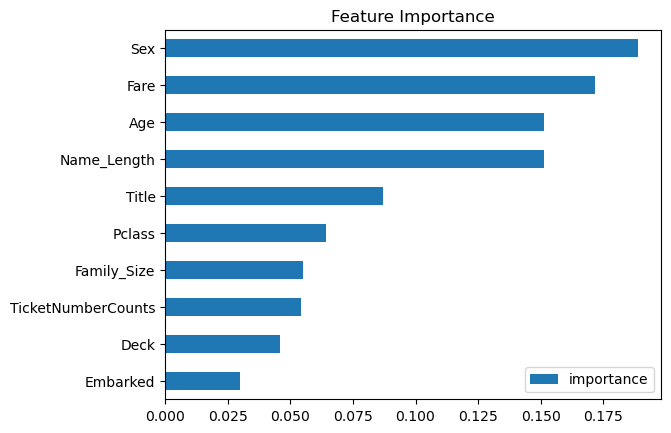

In [50]:
fi.sort_values('importance').plot(kind='barh',title='Feature Importance')
plt.show()

Once again the most important feature is Sex followed by Fare and Age. The least important is Embarked feature, which could be dropped if desired.

## Model Building

We are going to train several classifiers with default parameters and evaluate them using cross-validation score.

In [51]:
rf_clf = RandomForestClassifier()
adb_clf = AdaBoostClassifier()
knn_clf = KNeighborsClassifier()
xgb_clf = XGBClassifier()
lr = LogisticRegression()
svc_clf = SVC()

In [52]:
v_clf = VotingClassifier(estimators=[('rf',rf_clf),('adb',adb_clf),('xgb',xgb_clf),('knn',knn_clf),('lr',lr),('svc',svc_clf)])

In [53]:
model_list = [rf_clf,adb_clf,knn_clf,xgb_clf,lr,svc_clf,v_clf]

In [54]:
def get_acc_score(model_list):
    acc_scores = []
    for model in model_list:
        #score = cross_val_score(model, X_train, y_train, cv=5,scoring='accuracy',n_jobs=-1).mean()
        model.fit(X_train, y_train)
        ypred = model.predict(X_valid)
        score = accuracy_score(y_valid,ypred)
        acc_scores.append(round(score*100,3))
        
    d = {'Model': model_list,'Acc_Score':acc_scores}
    acc_df = pd.DataFrame(d)
    
    return acc_df

In [55]:
get_acc_score(model_list).sort_values(by='Acc_Score',ascending=False)

,Model,Acc_Score
1,"(DecisionTreeClassifier(max_depth=1, random_st...",82.123
5,SVC(),81.564
6,"VotingClassifier(estimators=[('rf', RandomFore...",81.006
0,"(DecisionTreeClassifier(max_features='sqrt', r...",79.330
4,LogisticRegression(),79.330
2,KNeighborsClassifier(),76.536
3,"XGBClassifier(base_score=None, booster=None, c...",75.419


## Submission

In [56]:
v_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('adb', AdaBoostClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('knn', KNeighborsClassifier()),
                             ('lr', LogisticRegression()), ('svc', SVC())])

In [57]:
pred = v_clf.predict(X_test)

In [58]:
submission = pd.DataFrame({
    'PassengerId': X_test.index,
    'Survived': pred
})

In [59]:
submission.to_csv('02_23_2024-vc.csv', index=False)

# Pipeline Processing

We can automate the whole machine learning process from data acquisition to model fitting using pipelines.

In [2]:
df_train = pd.read_csv("train.csv",index_col='PassengerId')
df_test = pd.read_csv("test.csv",index_col='PassengerId')

In [3]:
y = df_train['Survived']
X = df_train.drop('Survived',axis=1)
X_test = df_test

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify = y,random_state=42)

## Setting encoders and transformers

First we define ordinal encoder and power transformer.

In [5]:
ord_encoder = OrdinalEncoder().set_output(transform="pandas")

In [6]:
pt = PowerTransformer(method='yeo-johnson')

## Pipeline and Column Transformer

Now, it's time to create additional transformers out of our previous functions to use them in our pipeline.

In [8]:
def create_features(df):
        df = df.copy()
        # Fill NaN values in Fare and Age
        df['Fare'] = df['Fare'].fillna(df['Fare'].median())
        df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
        # Extracting Title from Name
        df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=False)
        df['Title'] = df['Title'].replace(['Capt', 'Col','Major'], 'Mr')
        df['Title'] = df['Title'].replace(['Rev', 'Dr'], 'Mr')
        df['Title'] = df['Title'].replace(['Don', 'Sir', 'Jonkheer'], 'Mr')
        df['Title'] = df['Title'].replace('Mlle', 'Miss')
        df['Title'] = df['Title'].replace(['Mme','Ms'], 'Mrs')
        df['Title'] = df['Title'].replace(['Lady', 'Countess','Dona'],'Mrs')
        # Extracting Name Length
        df['Name_Length'] = df['Name'].apply(lambda x: len(x))
        #Extracting Deck from Cabin
        df['Deck'] = df['Cabin'].fillna("U")
        df['Deck'] = df['Deck'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
        df['Deck'] = df['Deck'].apply(lambda x: 0 if x=='U' else 1)
        #extracting Ticket Number Counts from Ticket
        #ticket_map = {1: 0, 2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2}
        df['TicketNumber'] = df['Ticket'].apply(lambda x: x.split()[-1]) 
        df['TicketNumberCounts'] = df.groupby('TicketNumber')['TicketNumber'].transform('count')
        #df['TicketNumberCounts']  = df['TicketNumberCounts'].map(ticket_map)
        df = df.drop('TicketNumber',axis=1)
        #Extracting Family Size from SibSp and Parch
        #family_map = {1: 0, 2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 2, 8: 3, 11: 3}
        df['Family_Size'] = df['SibSp'] + df['Parch'] + 1
        #df['Family_Size'] = df['Family_Size'].map(family_map)       
        #Dropping Transformed features
        df = df.drop(['Name','SibSp','Parch','Ticket','Cabin'], axis = 1)

        return df

In [9]:
def fill_age(df):
    df = df.copy() 
    # Extracting Title from Name
    titles = df['Title'].unique().tolist() 
    for title in titles:
        
        mean = df.loc[df['Title']==title,'Age'].mean()
        std = df.loc[df['Title']==title,'Age'].std()
        length = df.loc[df['Title']==title,'Age'].isnull().sum() 
        
        to_fill = np.random.randint(mean-std,mean+std,length)
        df.loc[(df['Title']==title) & (df['Age'].isnull()),'Age'] = to_fill
    return df       

In [10]:
create_feat = FunctionTransformer(create_features)
age_feat = FunctionTransformer(fill_age)

Using a ColumnTransformer we can specify transformations for individual columns in our dataset. In our case I will use only the ordinal encoder for Sex, Title, Deck and Embarked. The remaining columns will stay unchanged.

In [66]:
col_transf = ColumnTransformer(transformers=[
    ('ord_encoding',ord_encoder,['Sex','Title','Deck','Embarked']),
    ('passthrough','passthrough',['Age','Pclass','Fare','Name_Length','TicketNumberCounts','Family_Size'])
    ],remainder='drop',                               
    n_jobs=-1)

Now we can defined a pre-processing pipeline, with all the previous steps incorporating at the end the power transformer using the Yeo-Johson method.

In [67]:
preprocessing_pipeline = Pipeline(
    steps=[
        ('create_feat',create_feat),  
        ('fill_age',age_feat),
        ('col_transf',col_transf),
        ('pow_transf',pt)
    ])

In [68]:
set_config(display='diagram')
display(preprocessing_pipeline)

Pipeline(steps=[('create_feat',
                 FunctionTransformer(func=<function create_features at 0x0000023345F0C4A0>)),
                ('fill_age',
                 FunctionTransformer(func=<function fill_age at 0x0000023345F0C5E0>)),
                ('col_transf',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('ord_encoding',
                                                  OrdinalEncoder(),
                                                  ['Sex', 'Title', 'Deck',
                                                   'Embarked']),
                                                 ('passthrough', 'passthrough',
                                                  ['Age', 'Pclass', 'Fare',
                                                   'Name_Length',
                                                   'TicketNumberCounts',
                                                   'Family_Size'])])),
                ('pow_transf', PowerTransformer())])

## Adding a Model

Finally as our last step we need to add a classifier to make predictions, let's choose the voting classifier to this end.

In [69]:
model = v_clf

In [70]:
pipeline_clf = make_pipeline(preprocessing_pipeline,model)

In [71]:
display(pipeline_clf)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('create_feat',
                                  FunctionTransformer(func=<function create_features at 0x0000023345F0C4A0>)),
                                 ('fill_age',
                                  FunctionTransformer(func=<function fill_age at 0x0000023345F0C5E0>)),
                                 ('col_transf',
                                  ColumnTransformer(n_jobs=-1,
                                                    transformers=[('ord_encoding',
                                                                   OrdinalEncoder(),
                                                                   ['Sex',
                                                                    'Title',
                                                                    'Deck',
                                                                    'Embarked']),
                                                                  ('passthrough',
                                                                   '...
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...)),
                                              ('knn', KNeighborsClassifier()),
                                              ('lr', LogisticRegression()),
                                              ('svc', SVC())]))])

We are in position to fit our entire pipeline to the training dataset, in order to make predictions.

In [72]:
pipeline_clf.fit(X_train,y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('create_feat',
                                  FunctionTransformer(func=<function create_features at 0x0000023345F0C4A0>)),
                                 ('fill_age',
                                  FunctionTransformer(func=<function fill_age at 0x0000023345F0C5E0>)),
                                 ('col_transf',
                                  ColumnTransformer(n_jobs=-1,
                                                    transformers=[('ord_encoding',
                                                                   OrdinalEncoder(),
                                                                   ['Sex',
                                                                    'Title',
                                                                    'Deck',
                                                                    'Embarked']),
                                                                  ('passthrough',
                                                                   '...
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...)),
                                              ('knn', KNeighborsClassifier()),
                                              ('lr', LogisticRegression()),
                                              ('svc', SVC())]))])

In [73]:
y_pred = pipeline_clf.predict(X_valid)
accuracy = accuracy_score(y_valid,y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.24%


## Submission

In [74]:
pred = pipeline_clf.predict(X_test)

In [75]:
submission = pd.DataFrame({
    'PassengerId': X_test.index,
    'Survived': pred
})

In [76]:
submission.to_csv('02_23_2024-vc.csv', index=False)